# Post-Processing Psuedo Surge Runs

In [1]:
import os 
import sys
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.colors as mcolors

plt.rcParams['text.usetex'] = False


In [2]:
bed  = xr.load_dataset('../Synthetic/exp_01_elevation_dependent/hdf5/LK_PRE_2000a_dt_1_dx_50_MB_1.90_OFF.nc').isel(t=0).z_s
test = xr.load_dataset("/Users/andrewnolan/OneDrive - Simon Fraser University (1sfu)/Harmonic_Beds_DataShare/R_0.01/pseudo_k_01-15_10a_dt_0.1_dx_50_mb_1.96_off.nc")
test["H"] = test.z_s - test.z_b

In [3]:
def make_colorbar(mf_dataset):
    #---------------------------------------------------------------------------
    # For Seting up the colorbar:
    #    - http://csc.ucdavis.edu/~jmahoney/matplotlib-tips.html
    #---------------------------------------------------------------------------
    cmap = cm.PuRd
    norm = mcolors.Normalize(vmin=np.min(mf_dataset.t),
                             vmax=np.max(mf_dataset.t))

    s_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    s_map.set_array(mf_dataset.t)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (mf_dataset.t[1] - mf_dataset.t[0]) / 2.0
    bounds   = np.linspace(mf_dataset.t[0]   - halfdist,
                           mf_dataset.t[-1]  + halfdist,
                           len(mf_dataset.t) + 1)

    return cmap, norm, s_map, bounds

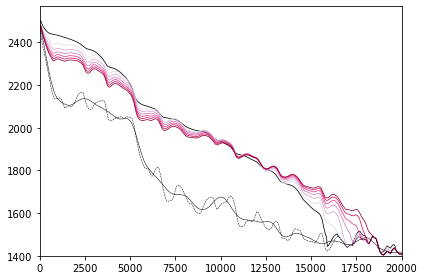

In [4]:
cmap, norm, s_map, bounds = make_colorbar(test)
   
plt.plot(test.x[::-1], 
         test.isel(t=0).z_s,
         lw=0.75,
         c='k')
    
for t in test.t[15::15]: 
    color = cmap(norm(t))
    plt.plot(test.x[::-1], 
             test.sel(t=t).z_s,
             lw=0.75,
             c=color)
plt.plot(test.x[::-1], bed,  c='k', lw =0.5)
plt.plot(test.x[::-1], test.isel(t=-1).z_b, c='k', ls ='--', lw =0.5)

plt.xlim(0, 20e3)
plt.ylim(1400, None)

plt.tight_layout()
#plt.savefig('/Users/andrewnolan/Desktop/fig5.png', dpi=1000, bbox_inches='tight', facecolor='w')

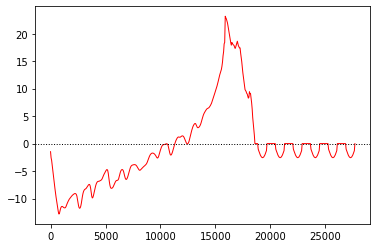

In [5]:
plt.plot(test.x[::-1], 
         (test.H.isel(t=-1) - test.H.isel(t=0)) / 10.1, 
         lw=1.0,
         c='r')

plt.axhline(0.0, c='k', ls=':', lw=1.0)

In [8]:
fp      = '/Users/andrewnolan/OneDrive - Simon Fraser University (1sfu)/Harmonic_Beds_DataShare/R_0.01/*'
files   = sorted(glob.glob(fp))
files.append(files.pop(1))

xarrays = []
for file in files:
    xarrays.append(xr.open_dataset(file))
    
mf_dataset = xr.concat(xarrays, 
                       pd.Index(np.arange(0,17), name='k'))

In [9]:
string = """\
WARNING:
    the 16th value of k is the summed 
"""
mf_dataset.k.attrs['description'] = string

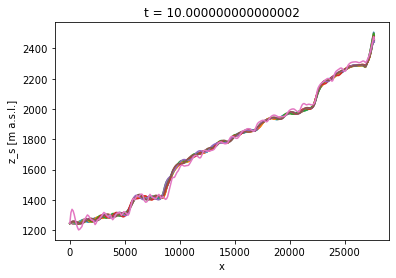

In [10]:
mf_dataset.isel(t=-1).z_s.plot.line(x="x", add_legend=False);

In [11]:
x    = np.ma.masked_array(mf_dataset.x.data) / 1e3
z_s  = np.ma.masked_array(mf_dataset.z_s.data)
z_b  = np.ma.masked_array(mf_dataset.z_b.data)
bed  = np.ma.masked_array(bed.data)
mask = (z_s - z_b) < 10.

z_s.mask = mask
z_b.mask = mask
bed.mask = mask[0,:,0]

In [12]:
def smooth(x):
    """6-th order low-pass butterworth filter
    """
    import scipy.signal as signal
    sos = signal.butter(6, 1/1.4e3,'low', fs=1/50, output='sos')

    return signal.sosfiltfilt(sos, x)

smoothed = mf_dataset.z_s.isel(t=-1).groupby("k").map(smooth)

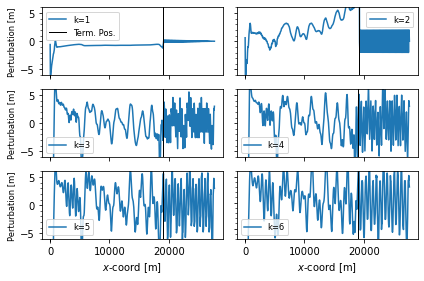

In [14]:
fig, axes = plt.subplots(3,2, sharex=True, sharey=True)

# pert     = (np.apply_along_axis(smooth, 1, z_s[:,:,-1]) - z_s[:,:,-1])
bed_pert   = smooth( z_s[0,:,-1])
term_loc = ((z_s[:,:,-1] - z_b[:,:,-1]) != 0).argmax(axis=1)

for i, ax in enumerate(axes.ravel()):
    #ax.plot(x[::-1], pert[i+1,:] - pert[0,:], label='k={}'.format(i+1))
    
    pert = (mf_dataset.isel(k=i+1,t=-1).z_s - mf_dataset.isel(k=0,t=-1).z_s) 
    ax.plot(mf_dataset.x[::-1], pert, label='k={}'.format(i+1))
    
    if i == 0: 
        ax.axvline(mf_dataset.x[::-1][term_loc[i+1]], label='Term. Pos.', ls='-', color='k', lw=1.0)
    else:
        ax.axvline(mf_dataset.x[::-1][term_loc[i+1]], ls='-', color='k', lw=1.0)
    ax.legend(fontsize='small')
        
    if i % 2 == 0: 
        ax.set_ylabel('Perturbation [m]', fontsize='small')
    
    if i >= 4: 
        ax.set_xlabel('$x$-coord [m]')
        
axes[-1,-1].set_ylim(-6,6)
axes[-1,-1].set_yticks(np.arange(-7, 7), minor=True);
axes[-1,-1].set_xticks(np.arange(0, 29, 1), minor=True);

plt.tight_layout()
plt.savefig('/Users/andrewnolan/Desktop/pert.png', dpi=400, bbox_inches='tight', facecolor='w')

In [ ]:
simple_line = mf_dataset.z_s.isel(t=-1).plot(
    x="x", hue="k", col="k", col_wrap=4
)

for i, ax in enumerate(simple_line.axes.ravel()):
    if i < len(mf_dataset.k):
        ax.plot(mf_dataset.x, mf_dataset.isel(k=i).z_b, color='k')
        ax.plot(smoothed.x,   mf_dataset.isel(k=0, t=-1).z_s, color='r')
    
#plt.savefig('/Users/andrewnolan/Desktop/smoothed_z_s_mean.png', dpi=400, bbox_inches='tight', facecolor='w')

In [ ]:
plt.plot(mf_dataset.x[::-1], mf_dataset.isel(k=8, t=-1).z_s)
plt.plot(mf_dataset.x[::-1], mf_dataset.isel(k=9, t=-1).z_s)
plt.plot(mf_dataset.x[::-1], mf_dataset.isel(k=1, t=-1).z_b, color='k')

#plt.savefig('/Users/andrewnolan/Desktop/k=8.png', dpi=400, bbox_inches='tight', facecolor='w')

In [ ]:
x    = np.loadtxt('../Data/Topography/pert_r_0.01_harmonics_02.dat')[:,0]
pert =np.loadtxt('../Data/Topography/pert_r_0.01_harmonics_02.dat')[:,1] - np.loadtxt('../Data/Topography/REF_BedTopo.dat')[:,1]

In [ ]:
plt.plot(mf_dataset.x, mf_dataset.isel(k=2, t=-1).z_b - mf_dataset.isel(k=0, t=-1).z_b)
#plt.plot(mf_dataset.x, mf_dataset.isel(k=0, t=-1).z_b)

#plt.savefig('/Users/andrewnolan/Desktop/test.png',dpi=600)

In [ ]:
import scipy.signal as signal

f, Pxx_den = signal.periodogram(pert, fs=1/10)

plt.plot(1/f, Pxx_den)
plt.xlim(0, 250)

In [ ]:
# import numpy as np 
# import xarray as xr 

# from scipy import interpolate
# import matplotlib.pyplot as plt 
# from matplotlib import animation, rc


# plt.rcParams['text.usetex'] = True
# plt.rcParams['animation.html'] = 'jshtml'


# fp = '../Synthetic/Exp_02_Sliding/Farinotti_filter_Savgol_p5_w21/h5/Farinotti_filter_Savgol_p5_w21.nc'
# fp = '/Users/andrewnolan/sfuvault/ELMERICE/Synthetic/Synthetic/perturbed_ratio-0.01/harmonics_1-10/Exp_02_Sliding/h5//pseduo_surge_test_int.nc'
# Data = xr.open_dataset(fp)


In [ ]:
!ls $fp

In [ ]:
# Make space time grid /for pcolormesh
XX, TT = np.meshgrid(Data.x, Data.t)

# Add varibales H (ice thickness) to dataset
Data['H'] =  Data.z_s -  Data.z_b

In [ ]:
#Data.close()

In [ ]:
Data.info()

In [ ]:
plt.pcolormesh(TT, XX/1000., Data.v_b.T,shading='auto')
plt.colorbar()

In [ ]:
Data.t

In [ ]:
plt.pcolormesh(TT, XX/1000., Data.v_s.T, vmin=0, vmax=500, shading='auto')
plt.colorbar()

In [ ]:
plt.plot(Data.x, Data.isel(t=0).v_s)
plt.plot(Data.x, Data.isel(t=0).v_mean)

Page 310 of Cuffey and Patterson: 

> These relations also show that surface velocity and depth-averaged velocity are similar. If
ub = 0, Eqs. 8.35 and 8.36 give u/us = [n +1]/[n +2] = 0.8 for n = 3. If, on the other hand,
motion is entirely by slip, u = us = ub. This sets limits on the likely value of the depth-averaged
velocity.

In [ ]:
plt.plot(Data.x,Data.isel(t=0).v_mean / Data.isel(t=0).v_s)

In [ ]:
fig, ax = plt.subplots(1,1)

im   = ax.pcolormesh(TT, XX/1000., (Data.z_s - Data.z_b).T,shading='gouraud')
cbar = fig.colorbar(im)
cbar.set_label('$\Delta H$ (m)',rotation=270,labelpad=20)

ax.set_ylabel('x coord. (km)')
ax.set_xlabel('Time (a)')
ax.set_title('Uncorrected Ice Thickness')

# fig.savefig('/Users/andrewnolan/Desktop/space_time_4_Alexi_&_Gwenn/00_Uncorrected_H.png', 
#             dpi = 600, bbox_inches='tight', facecolor='w')

In [ ]:
import scipy.signal as signal


In [ ]:
f, Pxx = signal.periodogram(Data.z_b.isel(t=-1), scaling='spectrum')
plt.plot(f,np.sqrt(Pxx))

f, Pxx = signal.periodogram(Data.z_s.isel(t=-1), scaling='spectrum')
plt.plot(f,np.sqrt(Pxx))

plt.yscale('log')
plt.ylim(10e-1, None)

Clearly, we still have some pimples downstream of the terminus which need to be corrected. 

In [ ]:
def first_nonzero(arr, axis, invalid_val=-1):
    """https://stackoverflow.com/a/47269413/10221482"""
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

In [ ]:
# Find where the ice thickness is less than 0
mask       = (Data.H.values[::-1] < 10.).astype(np.int)
# Find the first point where __mask__ is nonzero, i.e. there is no ice thickness
fist_point = first_nonzero(mask, axis = 0)
# Itterare over the first non-zero points. Set all downstream of it 
# to 1 (i.e. True meaning ice thickness should be 0).
for i, point in enumerate(fist_point): 
    mask[point:, i] = 1

In [ ]:
fig, ax = plt.subplots(1,1)

im   = ax.pcolormesh(TT, XX/1000., mask[::-1].T, shading='gouraud')
cbar = fig.colorbar(im)
cbar.set_label('Boolean (0 = False, 1 = True)',rotation=270,labelpad=20)

ax.set_ylabel('x coord. (km)')
ax.set_xlabel('Time (a)')
ax.set_title('Valid Ice Thickness Mask')

# fig.savefig('/Users/andrewnolan/Desktop/space_time_4_Alexi_&_Gwenn/01_Valid_H_mask.png', 
#             dpi = 600, bbox_inches='tight', facecolor='w')

In [ ]:
fig, ax = plt.subplots(1,1)

im = ax.pcolormesh(TT, XX/1000., 
                   Data.H.values.T - np.where(mask[::-1] == 0, Data.H.values, 0).T, 
                   shading='gouraud',
                   cmap = 'Reds')

cbar = fig.colorbar(im)
cbar.set_label('$\Delta H$ (m)',rotation=270,labelpad=20)

ax.set_ylabel('x coord. (km)')
ax.set_xlabel('Time (a)')
ax.set_title('Ice Thickness Correction')

# fig.savefig('/Users/andrewnolan/Desktop/space_time_4_Alexi_&_Gwenn/02_H_correction.png', 
#             dpi = 600, bbox_inches='tight', facecolor='w')

In [ ]:
Data.z_s.values  =  np.where(mask[::-1] == 0, Data.z_s.values, Data.z_b.values)
Data.v_s.values  =  np.where(mask[::-1] == 0, Data.v_s.values, 0)
Data.v_b.values  =  np.where(mask[::-1] == 0, Data.v_b.values, 0)
Data.H.values    =  np.where(mask[::-1] == 0, Data.H.values,   0)

In [ ]:
fig, ax = plt.subplots(1,1)

im   = ax.pcolormesh(TT, XX/1000., Data.H.T,shading='gouraud')
cbar = fig.colorbar(im)
cbar.set_label('$H$ (m)',rotation=270,labelpad=20)

ax.set_ylabel('x coord. (km)')
ax.set_xlabel('Time (a)')
ax.set_title('Corrected Ice Thickness')

# fig.savefig('/Users/andrewnolan/Desktop/space_time_4_Alexi_&_Gwenn/03_corrected_H.png', 
#             dpi = 600, bbox_inches='tight', facecolor='w')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
# for t in range(12):

plt.plot(Data.x, np.where(mask == 0, Data.H.values[::-1], 0)[:, 13])

In [ ]:
fig, ax = plt.subplots(1,1)

im = ax.pcolormesh(TT,
                   XX/1000.,
                   Data.v_s.T,
                   cmap='magma',
                   shading='gouraud')


ax.set_ylabel('x coordinate (km)')
ax.set_xlabel('Time (a)')
ax.set_title('Surface Velocity')

cbar = fig.colorbar(im)
cbar.set_label(r'$v_{\rm s}$ (m a$^{-1}$)',rotation=270,labelpad=20)

# fig.savefig('/Users/andrewnolan/Desktop/space_time_4_Alexi_&_Gwenn/04_surf_vel.png', 
#             dpi = 600, bbox_inches='tight', facecolor='w')

In [ ]:
fig, ax = plt.subplots(1,1)

im = ax.pcolormesh(TT,
                   XX,
                   Data.beta.T,
                   cmap='magma',
                   shading='gouraud')

ax.set_ylabel('x coordinate')
ax.set_xlabel('Time (a)')
ax.set_title('Elmer/Ice Slip Coefficient')

cbar = fig.colorbar(im)
cbar.set_label(r'$\beta^{-2}$',rotation=270,labelpad=20)

# fig.savefig('/Users/andrewnolan/Desktop/space_time_4_Alexi_&_Gwenn/05_beta.png', 
#             dpi = 600, bbox_inches='tight', facecolor='w')

In [ ]:
fig, ax = plt.subplots(1,1)

im = ax.pcolormesh(TT,
                   XX/1000.,
                   Data.v_b.T,
                   cmap='magma',
                   shading='gouraud')


ax.set_ylabel('x coordinate (km)')
ax.set_xlabel('Time (a)')
ax.set_title('Basal Velocity')

cbar = fig.colorbar(im)
cbar.set_label(r'$v_{\rm b}$ (m a$^{-1}$)',rotation=270,labelpad=20)

# fig.savefig('/Users/andrewnolan/Desktop/space_time_4_Alexi_&_Gwenn/06_bed_vel.png', 
#             dpi = 600, bbox_inches='tight', facecolor='w')

In [ ]:
fig, ax = plt.subplots(1,1)

im = ax.pcolormesh(TT,
                   XX/1000.,
                   100*((Data.v_b/ Data.v_s).T),
                   cmap='magma',
                   vmin = 0, 
                   vmax = 100, 
                   shading='gouraud')

ax.set_ylabel('x coordinate')
ax.set_xlabel('Time (a)')
ax.set_title(r'Fractional \% of $v_{\rm s}$ from $v_{\rm b}$')

cbar = fig.colorbar(im)
cbar.set_label(r'$ 100 \times \frac{v_{\rm b}}{v_{\rm s}}$ (\%)', rotation=270,labelpad=20)

# fig.savefig('/Users/andrewnolan/Desktop/space_time_4_Alexi_&_Gwenn/07_fractional_sliding.png', 
#             dpi = 600, bbox_inches='tight', facecolor='w')

# A nice animation: 

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6.6667,4))

ax.set_xlim(Data.x.min(), Data.x.max())
ax.set_ylim(Data.z_s.min()-25, Data.z_s.max()+200)
ax.set_ylabel('m a.s.l.')
ax.set_xlabel('x-coord (m)')

ax.plot( Data.x,Data.isel(t=0).z_b,color='saddlebrown')
ax.fill_between(Data.x, np.ones(Data.x.shape[0])*ax.get_ylim()[0], Data.isel(t=0).z_b, color='saddlebrown', alpha=0.5)

collection = ax.fill_between(Data.x, Data.isel(t=0).z_b, Data.isel(t=0).z_s, color='lightblue', alpha=0.5)

ax.plot(Data.x, Data.isel(t=0).z_s, 'k:', alpha=0.5, label='$z_s(t=0.0)$')
ax.legend()


ax.set_title(r'$z_{\rm b}(x) = z_{\rm b_{\rm F}} + \sum_{k=1}^{10} A_{k} \sin \left( \frac{2 \pi}{k \bar H} x \right)$')
ax.set_aspect(9)

line1, = ax.plot([], [], lw=2, color='lightblue', label='$z_s(t=0.0)$',)
line   = [line1]

def animate(i):
    if i == 0:
        ax.collections.clear()
        line[0].set_data(Data.x, Data.isel(t=i).z_s)
        line[0].set_label('$z_s(t={{{:.1f}}})$'.format(i/10))

        ax.fill_between(Data.x, np.ones(Data.x.shape[0])*ax.get_ylim()[0], Data.isel(t=0).z_b, color='saddlebrown', alpha=0.5)
        ax.fill_between(Data.x, Data.isel(t=0).z_b, Data.isel(t=0).z_s, color='lightblue', alpha=0.5)
        ax.legend()
    else:
        ax.collections.clear()
        line[0].set_label('$z_s(t={{{:.1f}}})$'.format(i/10))
        line[0].set_data(Data.x,  Data.isel(t=i).z_s)
        ax.fill_between(Data.x, np.ones(Data.x.shape[0])*ax.get_ylim()[0], Data.isel(t=i).z_b, color='saddlebrown', alpha=0.5)
        ax.fill_between(Data.x, Data.isel(t=i).z_b, Data.isel(t=i).z_s, color='lightblue', alpha=0.5)
    
        ax.legend()

    return line

anim = animation.FuncAnimation(fig, animate, 
                               frames=range(0,Data.t.shape[0]), interval=100, blit=True)

plt.tight_layout()
plt.close()
anim

In [ ]:
anim.save('/Users/andrewnolan/Desktop/animation.mp4', fps=10, dpi=800)

# VTU files:

In [ ]:
import os
import meshio
import xarray as xr

In [ ]:
# Find the files matching out run/step name
fp = '../Synthetic/perturbed_10-harmonics_ratio-0.01/Exp_02_Sliding/'
fn_list = [os.path.join(fp,fn) for fn in os.listdir(fp) if 'pseduo_surge_test' in fn]
# Sort the file list based on the timestep
fn_list.sort(key=lambda i: int(i.split('_')[-1].split('.')[0][1:]))

In [ ]:
# tempdataset = xr.Dataset(data_vars = test_dict, 
#                          coords    = {'yvals' : (('ynode','xnode'),ydim),
#                           'xvals' : (('ynode','xnode'),xdim)} 
#                         )

In [ ]:
test_dict = {}
for key in mesh.point_data.keys():
    
    if key == 'mesh update':
        continue
        
    new_key = '_'.join(key.split(' '))

    if np.shape(mesh.point_data[key])[1] == 3: 
        test_dict[new_key+'_x'] = (('ynode','xnode'), mesh.point_data[key][:,0].reshape(ygrid_pts,xgrid_pts))
        test_dict[new_key+'_y'] = (('ynode','xnode'), mesh.point_data[key][:,1].reshape(ygrid_pts,xgrid_pts))
        test_dict[new_key+'_m'] = (('ynode','xnode'), 
                               vm(mesh.point_data[key][:,0].reshape(ygrid_pts,xgrid_pts), 
                                   mesh.point_data[key][:,1].reshape(ygrid_pts,xgrid_pts)))
    else:
        test_dict[new_key] = (('ynode','xnode'), mesh.point_data[key][:,0].reshape(ygrid_pts,xgrid_pts))
    
#     print( np.shape(mesh.point_data[key]))
#     # replace space in names with underscores
#     print('_'.join(key.split(' ')))

In [ ]:

#def vtu_read(fn_list, NX, NY):


#info about mesh grid (set by user in model - Mesh/mesh.grd )
xgrid_cells = 283
ygrid_cells = 10


xgrid_pts   = xgrid_cells + 1
ygrid_pts   = ygrid_cells + 1

xnodes      = np.array(range(xgrid_pts))      # ynodes 
ynodes      = np.array(range(ygrid_pts))      # xnodes
tsteps      = np.array(range(len(fn_list)))   # number of time steps

timestep = [] #list of data arrays
for path in fn_list:
    t_val = fn_list.index(path)
    print(path)
    mesh = meshio.read(path, file_format= 'vtu') #mesh the file

    velx = mesh.point_data['velocity'][:,0].reshape((ygrid_pts,xgrid_pts)) #reshape the mesh coordinates
    vely = mesh.point_data['velocity'][:,1].reshape((ygrid_pts,xgrid_pts))
    velm = vm(velx,vely)
    
    xdim = mesh.points[:,0].reshape((ygrid_pts,xgrid_pts))
    ydim = mesh.points[:,1].reshape((ygrid_pts,xgrid_pts))

    tempdataset = xr.Dataset(data_vars = {'vel_x' : (('ynode','xnode'), velx) ,
                                          'vel_y' : (('ynode','xnode'), vely) ,
                                          'vel_m' : (('ynode','xnode'), velm)},
                             coords    = {'yvals' : (('ynode','xnode'),ydim),
                                          'xvals' : (('ynode','xnode'),xdim)})
    timestep.append(tempdataset)

datacomb = xr.concat(timestep, dim='t')

In [ ]:
plt.rcParams['text.usetex'] = False

datacomb.sel(t=0).vel_m.plot.contourf(x = 'xvals', y = 'yvals', levels=25)

In [ ]:

plt.ylim(1200,2750)
plt.fill_between(x, np.ones(x.shape[0])*plt.ylim()[0], NS_dat[0,:,8], color='saddlebrown',alpha=0.5)

plt.pcolormesh(datacomb.sel(t=0).xvals,
               datacomb.sel(t=0).yvals, 
               datacomb.sel(t=0).vel_m,
               shading='gouraud')

plt.plot(x,NS_dat[0,:,7],ls='--',color='skyblue')
#plt.plot(x,NS_dat[0,:,8],ls='--',color='saddlebrown')


plt.colorbar()
plt.savefig('/Users/andrewnolan/Desktop/test.png',dpi=600,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,3))

ax.set_xlim(NS_dat[0,:,4].min(),NS_dat[0,:,4].max())
ax.set_ylim(NS_dat[0,:,8].min()-25, NS_dat[0,:,8].max()+200)
ax.set_ylabel('m a.s.l.')
ax.set_xlabel('x-coord (m)')

ax.plot(x,NS_dat[0,:,8],color='saddlebrown')
ax.fill_between(x, np.ones(x.shape[0])*ax.get_ylim()[0], NS_dat[0,:,8], color='saddlebrown', alpha=0.5)

ims = []
for t in np.arange(0,100): 
    im = ax.pcolormesh(datacomb.sel(t=t).xvals, 
                       datacomb.sel(t=t).yvals, 
                       datacomb.sel(t=t).vel_m, 
                       clim = (0, 200),
                       shading='gouraud')
    ims.append([im])

fig.colorbar(im, ax=ax)

#ims = [[im] for im in ims]
anim = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
plt.tight_layout()
plt.close()
anim

In [ ]:
datacomb.to_netcdf("/Users/andrewnolan/Desktop/test_xarray.nc")